# Importing Libraries

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Load Dataset & Data Preparation

In [2]:
transforms_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transforms_test = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

#Load Dataset
dataset = datasets.ImageFolder(root= os.path.join('/kaggle/input/vehicle-classification/Vehicles'), transform=transforms_train)

train_x, test_x = train_test_split(list(range(len(dataset))), train_size=0.8, random_state=32)
train_x, val_x = train_test_split(train_x, test_size=0.25, random_state=32)

data_train = Subset(dataset, train_x)
data_val = Subset(dataset, val_x)
data_test = Subset(dataset, test_x)

#Apply transformations
data_train.dataset.transforms = transforms_train
data_val.dataset.transforms = transforms_test
data_test.dataset.transforms = transforms_test

train_loader = DataLoader(data_train, batch_size=32,shuffle=True) 
val_loader = DataLoader(data_val, batch_size=32, shuffle=False)
test_loader = DataLoader(data_test, batch_size=32, shuffle=False)

# Model Architecture

In [3]:
class modelCNN(nn.Module):
    def __init__(self):
        super(modelCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        #self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        #self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        #self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        #self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 7)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 256 * 14 * 14)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
model = modelCNN()
model

modelCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=7, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training Model

In [5]:
num_epoch = 70
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

for epoch in range(num_epoch):
    #Training
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(train_loader, desc= f"Epoch : {epoch+1}/{num_epoch}", leave=False):\
        #Zero the Parameters Gradient
        optimizer.zero_grad()
        
        #Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        #Backwar Optimization & Loss
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    
    #Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_acc)
    
    print(f"Epoch: {epoch+1}/{num_epoch}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}%")

Epoch : 1/70:  70%|██████▉   | 73/105 [03:48<01:44,  3.28s/it]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1/70, Train Loss: 1.8284, Validation Loss: 1.7180, Accuracy: 26.8336%


Epoch: 2/70, Train Loss: 1.6040, Validation Loss: 1.3506, Accuracy: 47.4955%


Epoch: 3/70, Train Loss: 1.4255, Validation Loss: 1.2191, Accuracy: 51.4311%


Epoch: 4/70, Train Loss: 1.2945, Validation Loss: 1.2248, Accuracy: 54.4723%


Epoch: 5/70, Train Loss: 1.1971, Validation Loss: 1.0641, Accuracy: 61.4490%


Epoch: 6/70, Train Loss: 1.1035, Validation Loss: 0.9772, Accuracy: 66.1896%


Epoch: 7/70, Train Loss: 1.0667, Validation Loss: 0.9227, Accuracy: 67.8891%


Epoch: 8/70, Train Loss: 0.9997, Validation Loss: 0.8718, Accuracy: 70.8408%


Epoch: 9/70, Train Loss: 0.9541, Validation Loss: 0.8722, Accuracy: 69.5886%


Epoch: 10/70, Train Loss: 0.8812, Validation Loss: 0.8649, Accuracy: 70.0358%


Epoch: 11/70, Train Loss: 0.9280, Validation Loss: 0.8745, Accuracy: 70.1252%


Epoch: 12/70, Train Loss: 0.8692, Validation Loss: 0.8201, Accuracy: 71.0197%


Epoch: 13/70, Train Loss: 0.8664, Validation Loss: 0.7991, Accuracy: 72.1825%


Epoch: 14/70, Train Loss: 0.7999, Validation Loss: 0.7346, Accuracy: 73.5242%


Epoch: 15/70, Train Loss: 0.8067, Validation Loss: 0.7726, Accuracy: 73.7925%


Epoch: 16/70, Train Loss: 0.8005, Validation Loss: 0.6988, Accuracy: 77.5492%


Epoch: 17/70, Train Loss: 0.7561, Validation Loss: 0.6932, Accuracy: 75.5814%


Epoch: 18/70, Train Loss: 0.7439, Validation Loss: 0.9266, Accuracy: 67.8891%


Epoch: 19/70, Train Loss: 0.7521, Validation Loss: 0.6672, Accuracy: 77.3703%


Epoch: 20/70, Train Loss: 0.6950, Validation Loss: 0.7050, Accuracy: 74.2397%


Epoch: 21/70, Train Loss: 0.7456, Validation Loss: 0.6912, Accuracy: 76.0286%


Epoch: 22/70, Train Loss: 0.6737, Validation Loss: 0.6483, Accuracy: 77.3703%


Epoch: 23/70, Train Loss: 0.6796, Validation Loss: 0.6177, Accuracy: 77.9070%


Epoch: 24/70, Train Loss: 0.6923, Validation Loss: 0.6611, Accuracy: 78.1753%


Epoch: 25/70, Train Loss: 0.6632, Validation Loss: 0.6454, Accuracy: 78.8014%


Epoch: 26/70, Train Loss: 0.6498, Validation Loss: 0.6459, Accuracy: 78.1753%


Epoch: 27/70, Train Loss: 0.6823, Validation Loss: 0.5977, Accuracy: 80.2326%


Epoch: 28/70, Train Loss: 0.6241, Validation Loss: 0.6346, Accuracy: 78.8909%


Epoch: 29/70, Train Loss: 0.6267, Validation Loss: 0.6341, Accuracy: 78.5331%


Epoch: 30/70, Train Loss: 0.6079, Validation Loss: 0.5450, Accuracy: 81.8426%


Epoch: 31/70, Train Loss: 0.6145, Validation Loss: 0.5113, Accuracy: 83.3631%


Epoch: 32/70, Train Loss: 0.5890, Validation Loss: 0.5710, Accuracy: 79.9642%


Epoch: 33/70, Train Loss: 0.5693, Validation Loss: 0.5495, Accuracy: 81.3953%


Epoch: 34/70, Train Loss: 0.5650, Validation Loss: 0.6108, Accuracy: 79.2487%


Epoch: 35/70, Train Loss: 0.5680, Validation Loss: 0.5616, Accuracy: 82.1109%


Epoch: 36/70, Train Loss: 0.5566, Validation Loss: 0.5287, Accuracy: 81.0376%


Epoch: 37/70, Train Loss: 0.5689, Validation Loss: 0.5121, Accuracy: 83.9893%


Epoch: 38/70, Train Loss: 0.5704, Validation Loss: 0.7431, Accuracy: 75.6708%


Epoch: 39/70, Train Loss: 0.5754, Validation Loss: 0.5030, Accuracy: 82.1109%


Epoch: 40/70, Train Loss: 0.5640, Validation Loss: 0.5093, Accuracy: 82.9159%


Epoch: 41/70, Train Loss: 0.5399, Validation Loss: 0.5018, Accuracy: 82.9159%


Epoch: 42/70, Train Loss: 0.5366, Validation Loss: 0.4918, Accuracy: 83.5420%


Epoch: 43/70, Train Loss: 0.5219, Validation Loss: 0.5463, Accuracy: 81.3953%


Epoch: 44/70, Train Loss: 0.5147, Validation Loss: 0.5013, Accuracy: 83.4526%


Epoch: 45/70, Train Loss: 0.5185, Validation Loss: 0.5470, Accuracy: 82.5581%


Epoch: 46/70, Train Loss: 0.5007, Validation Loss: 0.5196, Accuracy: 83.0948%


Epoch: 47/70, Train Loss: 0.5146, Validation Loss: 0.5633, Accuracy: 83.0948%


Epoch: 48/70, Train Loss: 0.5102, Validation Loss: 0.5954, Accuracy: 79.7853%


Epoch: 49/70, Train Loss: 0.5219, Validation Loss: 0.5440, Accuracy: 81.3953%


Epoch: 50/70, Train Loss: 0.4793, Validation Loss: 0.4720, Accuracy: 83.8998%


Epoch: 51/70, Train Loss: 0.4943, Validation Loss: 0.4558, Accuracy: 84.1682%


Epoch: 52/70, Train Loss: 0.5157, Validation Loss: 0.5258, Accuracy: 82.8265%


Epoch: 53/70, Train Loss: 0.4987, Validation Loss: 0.4372, Accuracy: 84.5259%


Epoch: 54/70, Train Loss: 0.4743, Validation Loss: 0.5163, Accuracy: 83.0948%


Epoch: 55/70, Train Loss: 0.4900, Validation Loss: 0.5114, Accuracy: 83.3631%


Epoch: 56/70, Train Loss: 0.4961, Validation Loss: 0.4744, Accuracy: 84.5259%


Epoch: 57/70, Train Loss: 0.4921, Validation Loss: 0.5068, Accuracy: 82.8265%


Epoch: 58/70, Train Loss: 0.5130, Validation Loss: 0.4839, Accuracy: 84.0787%


Epoch: 59/70, Train Loss: 0.4748, Validation Loss: 0.4704, Accuracy: 83.9893%


Epoch: 60/70, Train Loss: 0.4567, Validation Loss: 0.4835, Accuracy: 82.5581%


Epoch: 61/70, Train Loss: 0.4535, Validation Loss: 0.5064, Accuracy: 82.0215%


Epoch: 62/70, Train Loss: 0.4705, Validation Loss: 0.5744, Accuracy: 79.7853%


Epoch: 63/70, Train Loss: 0.4706, Validation Loss: 0.4352, Accuracy: 85.6887%


Epoch: 64/70, Train Loss: 0.4702, Validation Loss: 0.5272, Accuracy: 83.3631%


Epoch: 65/70, Train Loss: 0.4397, Validation Loss: 0.4420, Accuracy: 85.2415%


Epoch: 66/70, Train Loss: 0.4285, Validation Loss: 0.5166, Accuracy: 82.9159%


Epoch: 67/70, Train Loss: 0.4648, Validation Loss: 0.5311, Accuracy: 81.9320%


Epoch: 68/70, Train Loss: 0.4451, Validation Loss: 0.4978, Accuracy: 82.3792%


Epoch: 69/70, Train Loss: 0.4339, Validation Loss: 0.4214, Accuracy: 87.0304%


Epoch: 70/70, Train Loss: 0.4517, Validation Loss: 0.4001, Accuracy: 87.0304%


# Training & Validation Performance Visualization

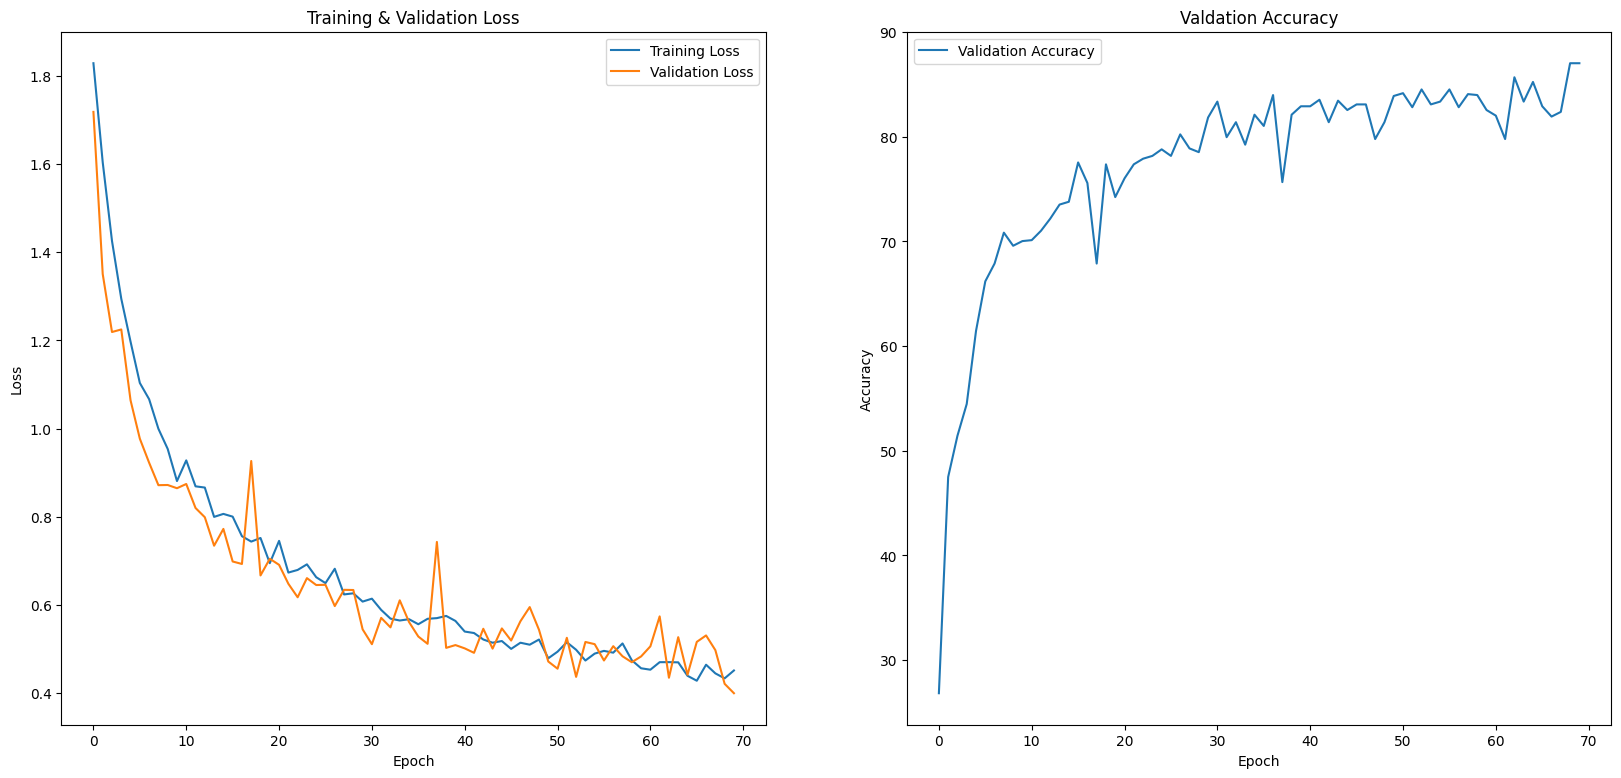

In [9]:
plt.figure(figsize=(20, 9))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title("Valdation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Test Model Performance

In [6]:
def test_evaluate(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc= "Testing", leave=False):
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss /= len(test_loader)
    test_acc = 100 * correct / total
    
    return test_loss, test_acc

test_loss, test_acc = test_evaluate(model, test_loader)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acuraccy: {test_acc:.4f}")

Test Loss: 0.4765
Test Acuraccy: 85.3309


# Save The Model

In [10]:
#Save Model
#torch.save(model.state_dict(), 'model_no_l2_regularization.pth')
model_save_path = "/kaggle/working/vehicle_classification_model.pth"
torch.save(model.state_dict(), model_save_path)

# Inference Model

In [8]:
model = modelCNN()

# Load state dict model from file uploaded
model_path = '/kaggle/input/vehicle_classification_model/pytorch/default/1/vehicle_classification_model.pth'
model.load_state_dict(torch.load(model_path))

# Make sure model is in the evaluation mode  to inference
model.eval()

/tmp/ipykernel_37/2390944869.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


modelCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=7, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

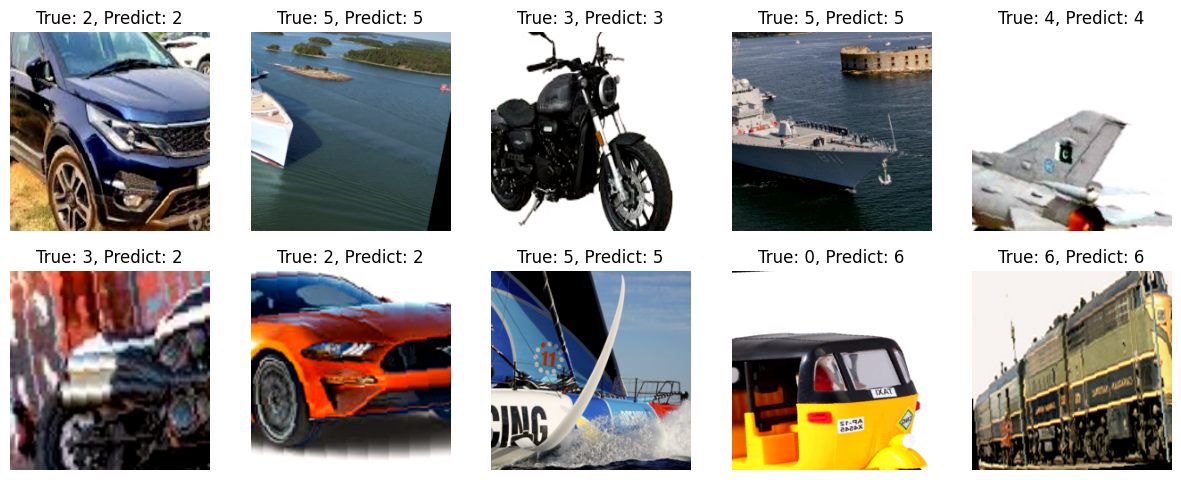

In [12]:
def plot_test_predictions(model, test_loader, num_samples=10):
    model.eval()
    X, y_true, y_pred = [], [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            X.extend(inputs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            if len(X) >= num_samples:
                break
    
    X = np.array(X[:num_samples]).transpose((0, 2, 3, 1))  # N x H x W x C
    X = X * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    X = np.clip(X, 0, 1)
    
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        plt.subplot(5, 5, i + 1)
        plt.imshow(X[i])
        plt.title(f"True: {y_true[i]}, Predict: {y_pred[i]}")
        plt.axis('off')
    plt.show()

plot_test_predictions(model, test_loader, num_samples=10)

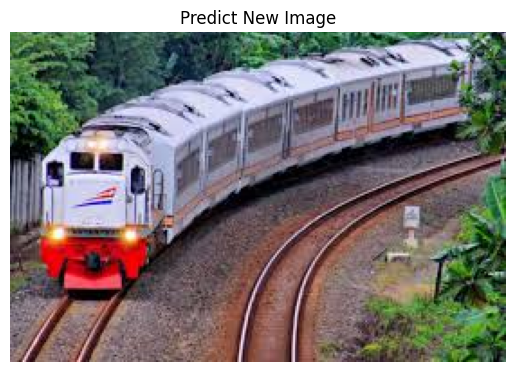

Predicted class: Trains


In [15]:
from PIL import Image
from torchvision import transforms

# Transforms iamge
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()

classes = ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycle', 'Planes', 'Ships', 'Trains']
img = Image.open('/kaggle/input/new-image/download (1).jpeg') 

plt.imshow(img)
plt.title("Predict New Image")
plt.axis('off')
plt.show()

img = transform(img).unsqueeze(0)

# Predict the image
with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output, 1)
    print(f'Predicted class: {classes[predicted.item()]}')